Initialing SparkSession and Loading Flight Data

In [31]:
# mounting the google drive to access the data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
#Install the Pyspark
!pip install pyspark

# importing the required classes
import pyspark
from pyspark.sql import SparkSession

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import SQLTransformer

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline 
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LinearSVC

import matplotlib.pyplot as plt
import numpy as np
import time

# creating a spark session
spark = SparkSession.builder.master('local[*]').appName('Flight Delay Prediction').getOrCreate()

# Load the pre-processed data from drive 
flights_df = spark.read.csv('/content/drive/MyDrive/532/ProcessedFlights', sep=',', header=True, inferSchema=True, nullValue='NA')

# printing the columns and their types
flights_df.show(5)
print(flights_df.dtypes)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+-------------------+---------------+----------------+-------------------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|carrier_transformed|org_transformed|dest_transformed|tailnum_transformed|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+-------------------+---------------+---------------

Pre-processing the flight data 

In [33]:
# Create an assembler object to consolidate the features
relevantCols = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'FlightNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'Diverted', 'carrier_transformed', 'org_transformed', 'dest_transformed', 'tailnum_transformed']
assembler = VectorAssembler(inputCols=relevantCols, outputCol='features')
flights_consolidate = assembler.transform(flights_df)

# Selecting the features and delay values using SQLTransformer
transformer = SQLTransformer(statement="SELECT ArrDelay, features FROM __THIS__")
flights_data = transformer.transform(flights_consolidate)

# Split the data for training and test
flights_train1, flights_test1 = flights_data.randomSplit([0.6, 0.4], seed=42)

In [34]:
# Start Execution time
time_init = time.time()

#Create a Linear Regression Model
linear_reg_model = LinearRegression(maxIter=200, regParam=0.5, elasticNetParam=0.1, featuresCol = 'features', labelCol = 'ArrDelay')

#Create a pipeline with the linear_regression_model
pipeline1 = Pipeline(stages=[linear_reg_model])

# define set of parameters for tuning the model
paramGrid1 = (ParamGridBuilder() \
    .addGrid(linear_reg_model.regParam, [0.1,0.5,1]) \
    .addGrid(linear_reg_model.elasticNetParam, [0.01, 0.1, 0.2]) \
    .addGrid(linear_reg_model.maxIter,[200])
    .build())

# Define the evaluator
evaluator1 = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="rmse")

# # Define the train-validation split
train_validation_split_linear = TrainValidationSplit(estimator=pipeline1, estimatorParamMaps=paramGrid1, evaluator=evaluator1, trainRatio=0.8)

#Train the model
model_linear_reg = train_validation_split_linear.fit(flights_train1)

#End the execution time
regression_speed = time.time()-time_init

In [35]:
#Displaying the model training summary
summary = model_linear_reg.bestModel.stages[-1].summary
print("numIterations: %d" % summary.totalIterations)
print("RMSE on train data %f" % summary.rootMeanSquaredError)
print("MAE on train data %f" % summary.meanAbsoluteError)
print("R2 on train data %f" % summary.r2)

numIterations: 97
RMSE on train data 57.524456
MAE on train data 36.747363
R2 on train data 0.102245


In [36]:
# predicting for the test data
predictions_linear_reg = model_linear_reg.transform(flights_test1)

#Evaluating the Test Data
# Evaluating for RMSE metric
lr_evaluator_mse = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="ArrDelay",metricName="rmse")

print("RMSE on test data = %g" % lr_evaluator_mse.evaluate(predictions_linear_reg))

# Evaluating for MAE metric
lr_evaluator_mae = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="ArrDelay",metricName="mae")

print("MAE on test data = %g" % lr_evaluator_mae.evaluate(predictions_linear_reg))

# Evaluating for R2 metric
lr_evaluator_r2 = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="ArrDelay",metricName="r2")

print("R2 on test data = %g" % lr_evaluator_r2.evaluate(predictions_linear_reg))

RMSE on test data = 57.6306
MAE on test data = 36.8134
R2 on test data = 0.102031


In [37]:
def plot_graph(model_name, predictions):
      #Processing the predictions to plot the graph
      pred = predictions.select('prediction').rdd.flatMap(lambda x: x)
      pred = [r[0] for r in predictions.select('prediction').toLocalIterator()]
      test = [r[0] for r in predictions.select('ArrDelay').toLocalIterator()]

      # plotting the graph with original and predicted values
      plt.plot(range(len(pred)), pred, label = "predicted delay")
      plt.plot(range(len(pred)), test, label = "original delay")
      plt.legend()
      plt.ylabel("delay value")
      plt.xlabel("test data")
      plt.title("Delay -- "+ model_name)
      plt.show()

Linear Regression - Graph


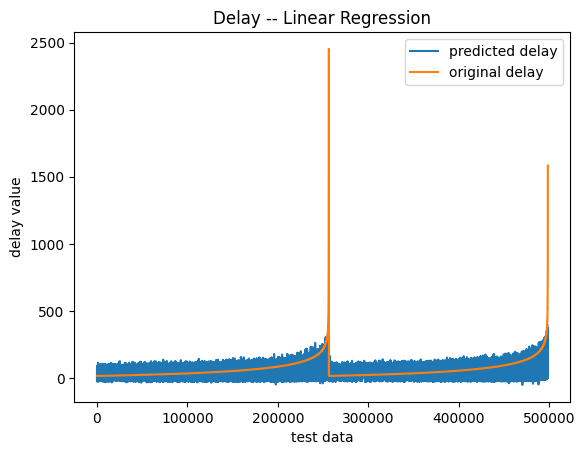

In [38]:
print("Linear Regression - Graph")
plot_graph("Linear Regression", predictions_linear_reg )

In [42]:
#Printing the Execution Time
print("Time taken for Linear Regression: ", regression_speed ,"seconds")

Time taken for Linear Regression:  75.06747341156006 seconds
